In [1]:
import os
import numpy as np
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, gaussian_kde, linregress, ttest_ind, sem, zscore
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import norm
from scipy.stats import percentileofscore
from sklearn.utils.validation import check_random_state
from math import factorial
from more_itertools import distinct_permutations
import statsmodels.api as sm

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

import numpy as np
from scipy.stats import linregress
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, ParameterGrid, train_test_split
from tqdm.notebook import tqdm

import warnings
import random
#from torch.utils.data import SubsetRandomSampler
from sklearn.utils import resample

from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.diagnostic import linear_harvey_collier
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from colorama import Fore, Style, init
from sklearn.metrics import roc_auc_score
from collections import Counter

from statsmodels.stats.diagnostic import linear_harvey_collier
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from colorama import Fore, Style, init
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")



In [2]:
from scipy.stats import chi2

def summarize_feature(df, feature, df_out, stat_cols=(10, 50), df_offset=2):

    d = df[df["Feature"] == feature]
    if d.empty:
        return df_out  

    for k in stat_cols:
        col = f"hl_statistic_{k}"
        if col in d.columns:
            df_chi = k - df_offset
            combined_p = 1 - chi2.cdf(d[col].mean(), df_chi)
            df_out.loc[feature, f"hl_pvalue_combined_{k}"] = combined_p

    # --- RR summary ---
    if "RR" in d.columns:
        or_mean = d["RR"].mean()
        or_std = d["RR"].std(ddof=1)
        df_out.loc[feature, "RR"] = or_mean
        df_out.loc[feature, "2.5%"] = or_mean - or_std
        df_out.loc[feature, "97.5%"] = or_mean + or_std

    # --- min/max de los IC originales (tal como lo estabas haciendo) ---
    if "2.5%" in d.columns:
        df_out.loc[feature, "minRR"] = d["2.5%"].min()
    if "97.5%" in d.columns:
        df_out.loc[feature, "maxRR"] = d["97.5%"].max()

    return df_out


features = ["Mono", "One", "Two", "Three", "Total"] 




def hosmer_lemeshow(y_true, y_prob, g):
    hl_df = pd.DataFrame({
        "observed": y_true,
        "predicted_probability": y_prob
    }).dropna()


    hl_df["group"] = pd.qcut(hl_df["predicted_probability"], g, duplicates="drop")

    hl_table = hl_df.groupby("group").apply(
        lambda x: pd.Series({
            "observed": x["observed"].sum(),
            "expected": x["predicted_probability"].sum(),
            "total": len(x)
        })
    )

    hl_table["observed_neg"] = hl_table["total"] - hl_table["observed"]
    hl_table["expected_neg"] = hl_table["total"] - hl_table["expected"]


    hl_statistic = (
        ((hl_table["observed"] - hl_table["expected"])**2) / hl_table["expected"] +
        ((hl_table["observed_neg"] - hl_table["expected_neg"])**2) / hl_table["expected_neg"]
    ).sum()


    dof = hl_table.shape[0] - 2
    p_value = 1 - chi2.cdf(hl_statistic, dof)

    return hl_statistic, p_value



def summarize_feature_by_covar(df, covar, feature, df_out, stat_cols=(10, 50), df_offset=2):
    d = df[(df["Covar"] == covar) & (df["Feature"] == feature)]
    if d.empty:
        return df_out

    idx = (covar, feature)

    for k in stat_cols:
        col = f"hl_statistic_{k}"
        if col in d.columns:
            df_chi = k - df_offset
            df_out.loc[idx, f"hl_pvalue_combined_{k}"] = 1 - chi2.cdf(d[col].mean(), df_chi)

    or_mean = d["RR"].mean()
    or_std  = d["RR"].std(ddof=1)
    df_out.loc[idx, "RR"] = or_mean
    df_out.loc[idx, "2.5%"] = or_mean - or_std
    df_out.loc[idx, "97.5%"] = or_mean + or_std

    df_out.loc[idx, "minRR"] = d["2.5%"].min()
    df_out.loc[idx, "maxRR"] = d["97.5%"].max()

    df_out.loc[idx, "n_iter"] = d.shape[0]

    return df_out


## Load data

In [3]:
data = pd.read_parquet('data/BBAG-long.parquet')

In [4]:
data = data[data.country != 'Slovakia'].reset_index(drop =  True)

In [5]:
Counter(data.country)

Counter({'Austria': 4320,
         'Belgium': 4942,
         'Czechia': 5575,
         'Switzerland': 2634,
         'Germany': 4567,
         'Denmark': 2609,
         'Estonia': 7522,
         'Spain': 4912,
         'France': 3640,
         'Hungary': 3010,
         'Italy': 4541,
         'Netherlands': 2546,
         'Poland': 3612,
         'Portugal': 1914,
         'Sweden': 2792,
         'Slovenia': 5291,
         'Luxembourg': 2104,
         'Greece': 2599,
         'Croatia': 2798,
         'Bulgaria': 1953,
         'Cyprus': 1205,
         'Finland': 1982,
         'Lithuania': 2033,
         'Latvia': 1684,
         'Malta': 1259,
         'Romania': 2083})

In [6]:
vars_ = ['Mono', 'One',	'Two',	'Three', 'Total']


## RR adding co-vars

In [7]:
covar_list = (
                'gender_equal_l', 'Polution_conc_inv', 'Eq', 'free_parties_l',  'inclu_suff_est', 'cred_elect_est', 'local_dem_est', 'GDP_per_capita',
                'number_leng_inst', 'number_stable_inst', 'distance', 'Migration'
)


In [8]:
#fit_logit_rr(results_merge_df_all, ["Mono"]+ ['delta_time'])

In [9]:
results_merge_df_all = data.copy()


In [10]:
def fit_logit_rr(df, features, ycol='GAP_bin'):
    try:
        c_df = df[features + [ycol]].dropna()


        X = c_df[features + ['delta_time']]
        y = c_df[ycol]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = MinMaxScaler((0.05, 0.95))
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )

        X_train_scaled['intercept'] = 1

        model = sm.GLM(y_train, X_train_scaled, family=sm.families.Binomial(link=sm.families.links.log())).fit(disp = 0)

        RR = np.exp(model.params[features[0]])
        return RR

    except ValueError as e:
        msg = str(e)
        if "invalid value detected in weights" in msg or "estimation infeasible" in msg:
            return None
        else:
            raise  # otros errores sí deben verse


In [11]:
results_all = []

for i in vars_:
    display(i)

    df_base = results_merge_df_all[[i, 'GAP_bin'] + list(covar_list) + ['delta_time']]

    # --- RR base ---
    RR_base = fit_logit_rr(df_base, [i] + ['delta_time'])

    if RR_base is None:
        print(f"[SKIP] {i}: RR base did not converge")
        continue  # pasa a la siguiente variable en vars_

    logRR_ref = np.log(RR_base)

    selected = []
    remaining = list(covar_list)
    step = 0

    while len(remaining) > 0:

        deltas = []

        for c in remaining:
            features = [i] + selected + [c]  + ['delta_time']

            RR_new = fit_logit_rr(df_base, features)

            if RR_new is None:
                continue  # ignora solo esta covariable candidata

            delta = abs(np.log(RR_new) - logRR_ref)

            deltas.append({
                'Feature': i,
                'Step': step + 1,
                'Candidate_covar': c,
                'RR_ref': np.exp(logRR_ref),
                'RR_new': RR_new,
                'Delta_logRR': delta
            })

        # Si ninguna covariable pudo evaluarse, corta este i
        if len(deltas) == 0:
            print(f"[STOP] {i}: no covariate could be evaluated at step {step+1}")
            break

        df_deltas = pd.DataFrame(deltas)
        best = df_deltas.sort_values('Delta_logRR').iloc[0]

        selected.append(best['Candidate_covar'])
        remaining.remove(best['Candidate_covar'])
        logRR_ref = np.log(best['RR_new'])
        step += 1

        best['Selected_covar'] = best['Candidate_covar']
        best['Selected_so_far'] = ', '.join(selected)
        results_all.append(best)


'Mono'

'One'

'Two'

'Three'

'Total'

In [12]:
df_stepwise_RR = pd.DataFrame(results_all)
df_stepwise_RR

,Feature,Step,Candidate_covar,RR_ref,RR_new,Delta_logRR,Selected_covar,Selected_so_far
4,Mono,1,inclu_suff_est,1.411362,1.409814,0.001097,inclu_suff_est,inclu_suff_est
7,Mono,2,number_leng_inst,1.409814,1.428603,0.013239,number_leng_inst,"inclu_suff_est, number_leng_inst"
8,Mono,3,distance,1.428603,1.428965,0.000253,distance,"inclu_suff_est, number_leng_inst, distance"
4,Mono,4,cred_elect_est,1.428965,1.423233,0.004020,cred_elect_est,"inclu_suff_est, number_leng_inst, distance, cr..."
4,Mono,5,local_dem_est,1.423233,1.406928,0.011522,local_dem_est,"inclu_suff_est, number_leng_inst, distance, cr..."
3,Mono,6,free_parties_l,1.406928,1.340235,0.048564,free_parties_l,"inclu_suff_est, number_leng_inst, distance, cr..."
0,Mono,7,gender_equal_l,1.340235,1.308664,0.023838,gender_equal_l,"inclu_suff_est, number_leng_inst, distance, cr..."
3,Mono,8,number_stable_inst,1.308664,1.387352,0.058391,number_stable_inst,"inclu_suff_est, number_leng_inst, distance, cr..."
0,Mono,9,Polution_conc_inv,1.387352,1.469841,0.057757,Polution_conc_inv,"inclu_suff_est, number_leng_inst, distance, cr..."
0,Mono,10,Eq,1.469841,1.255719,0.157446,Eq,"inclu_suff_est, number_leng_inst, distance, cr..."


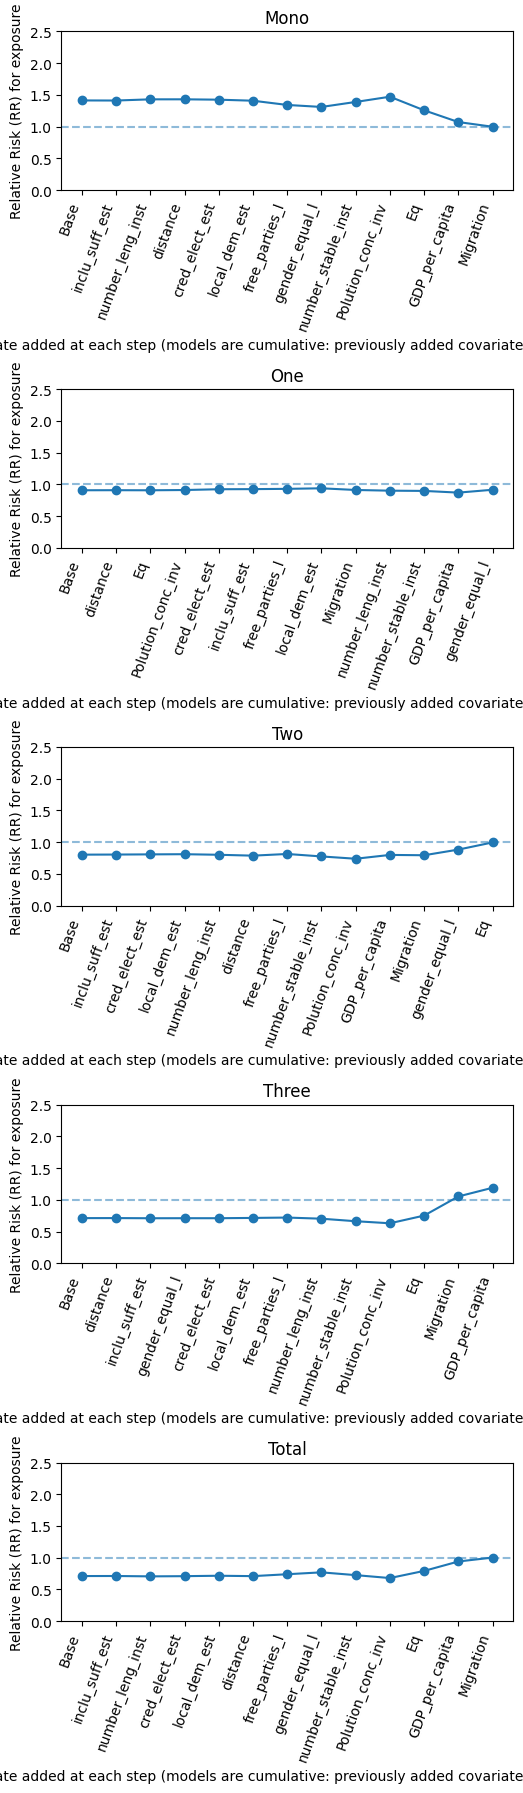

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 20))
count = 0
for v in vars_:
    d = df_stepwise_RR[df_stepwise_RR['Feature'] == v].copy()
    d = d.sort_values('Step')

    if d.empty:
        continue

    # RR base (sin covariables): está en RR_ref del Step 1
    RR_base = float(d.iloc[0]['RR_ref'])

    # Y: RR base + RR después de cada adición
    ors = [RR_base] + d['RR_new'].tolist()

    # X labels: Base + covariable agregada en cada paso
    xlabels = ['Base'] + d['Selected_covar'].tolist()
    x = list(range(len(xlabels)))

    count2 = 2*count + 1
    plt.subplot(6, 2, count2)
    plt.plot(x, ors, marker='o')
    plt.axhline(1, linestyle='--', alpha=0.5)

    plt.xticks(x, xlabels, rotation=70, ha='right')
    plt.xlabel('Covariate added at each step (models are cumulative: previously added covariates are retained)')
    plt.ylabel('Relative Risk (RR) for exposure')
    plt.title(f'{v}')
   
    plt.ylim([0,2.5])
    count+=1
plt.tight_layout()

plt.savefig("Figures_pdf/stepwise_RR_plots.pdf", format="pdf", bbox_inches="tight")

plt.show()
